# Preliminary

In [ ]:
# Check gpu runtime
from psutil import virtual_memory
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)

if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)
    ram_gb = virtual_memory().total / 1e9
    print('\n')
    print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Tue Apr 20 07:40:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Time code cell execution
!pip install ipython-autotime
%load_ext autotime

time: 143 µs (started: 2021-04-20 07:40:40 +00:00)


In [ ]:
# Hyperparameter tuning
!pip install ray

     |████████████████████████████████| 47.5MB 104kB/s 
     |████████████████████████████████| 204kB 57.0MB/s 
     |████████████████████████████████| 3.1MB 38.1MB/s 
     |████████████████████████████████| 71kB 10.3MB/s 
     |████████████████████████████████| 81kB 12.6MB/s 
     |████████████████████████████████| 81kB 11.3MB/s 
     |████████████████████████████████| 1.3MB 49.3MB/s 
     |████████████████████████████████| 133kB 60.6MB/s 
     |████████████████████████████████| 92kB 13.9MB/s 
     |████████████████████████████████| 296kB 55.1MB/s 
     |████████████████████████████████| 143kB 56.8MB/s 
  Created wheel for gpustat: filename=gpustat-0.6.0-cp37-none-any.whl size=12621 sha256=6741ff099f0a2f2e5cf59bd4f6ca74ba0375b8b2f0e3bd95f68e167de5e66204
  Stored in directory: /root/.cache/pip/wheels/48/b4/d5/fb5b7f1d040f2ff20687e3bad6867d63155dbde5a7c10f4293
Successfully built gpustat
time: 15.4 s (started: 2021-04-20 07:40:43 +00:00)


In [ ]:
# Hyperparameter tuning
!pip install tensorboardX

     |████████████████████████████████| 122kB 4.3MB/s 
time: 2.72 s (started: 2021-04-20 07:41:01 +00:00)


In [ ]:
# Imports
from   functools import partial
from   google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from   ray import tune
from   ray.tune import CLIReporter
from   ray.tune.schedulers import ASHAScheduler
from   sklearn.model_selection import train_test_split
import sys
import torch
import torch.nn as nn
from   torch.utils import data

time: 2.75 s (started: 2021-04-20 07:41:06 +00:00)


In [ ]:
# Plots
# https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
%matplotlib inline
plt.style.use('seaborn-darkgrid')

time: 3.98 ms (started: 2021-04-20 07:41:11 +00:00)


In [28]:
# Google Drive
drive.mount('/content/gdrive', force_remount=True)
sys.path.append('/content/gdrive/MyDrive/Uni/Year 3/ECS635U Project/')

Mounted at /content/gdrive
time: 662 ms (started: 2021-04-20 21:42:47 +00:00)


# Data

In [29]:
def load_data(datapoints='max', random_state=None):
    """
    Load examples from a csv file and create a training and testing dataset using
    a standard 80/20 split.

    Parameters
    ----------
    datapoints : int or str, default='max'
        Number of examples to load from the csv.
    random_state : int or None, default=None
        Controls the shuffling of data before being split. Pass a specific int
        for a reproducible split.

    Returns
    -------
    train_dataset : TensorDataset
        Dataset containing 80% of randomly selected examples from the csv.
    test_dataset : TensorDataset
        Dataset containing the remaining 20% of examples.
    """

    # Get data as dataframe
    df = pd.read_csv('/content/gdrive/MyDrive/Uni/Year 3/ECS635U Project/model_input_duolingo_subset.csv')
    max_datapoints = len(df)

    # Optionally use a subset of data
    if datapoints != 'max':
        assert datapoints <= max_datapoints, f'max datapoints is {max_datapoints}'
        df = df[:datapoints]
    
    # Separate features and labels
    df_x = df.drop('p_trans', axis=1)
    df_y = df['p_trans'].to_frame()

    # Create feature and label tensors
    x = torch.tensor(df_x.values, dtype=torch.float32)
    y = torch.tensor(df_y.values, dtype=torch.float32)

    # Split data into testing and training sets
    X_train, X_test, y_train, y_test = train_test_split(
        x, y,
        test_size=0.2,
        random_state=random_state)

    # Create datasets
    train_dataset = data.TensorDataset(X_train, y_train)
    test_dataset = data.TensorDataset(X_test, y_test)

    return train_dataset, test_dataset

time: 12.9 ms (started: 2021-04-20 21:43:18 +00:00)


# Model

In [ ]:
def init_weights(m):
    """Apply to a created model to initialise the weights and bias."""
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        torch.nn.init.zeros_(m.bias)

time: 1.64 ms (started: 2021-04-20 07:42:02 +00:00)


In [ ]:
class LangyBlock(nn.Module):
    """
    A block for a LangyNet model consisting of:
    - linear hidden layer
    - rectified linear activation function
    - dropout layer.

    Initialisation Parameters
    -------------------------
    id : int
        Block identification number.
    input_nodes : int
        Input size for the hidden layer.
    output_nodes : int
        Output size for the hidden layer i.e. number of hidden nodes.
    p_dropout : float, default=0
        Probability of a hidden layer node to be zeroed.

    Forward Parameters
    ------------------
    x : Tensor
        Size([batch_size, input_nodes])

    Returns
    -------
    x : Tensor
        Size([batch_size, output_nodes])

    """

    def __init__(self, id, input_nodes, output_nodes, p_dropout=0):
        super(LangyBlock, self).__init__()
        self.id = id
        self.input_nodes = input_nodes
        self.output_nodes = output_nodes
        self.p_dropout = p_dropout

        self.add_module(
            f'hid{self.id}',
            nn.Linear(self.input_nodes, self.output_nodes))
        self.add_module(
            f'act{self.id}',
            nn.ReLU())
        self.add_module(
            f'drop{self.id}',
            nn.Dropout(self.p_dropout))

    def forward(self, x):
        x = self._modules[f'hid{self.id}'](x)
        x = self._modules[f'act{self.id}'](x)
        x = self._modules[f'drop{self.id}'](x)
        return x

time: 11.6 ms (started: 2021-04-20 07:42:03 +00:00)


In [ ]:
class LangyNet(nn.Module):
    """
    A Multilayer Perceptron with a configurable number of hidden layers.

    Takes a Tensor of learning traces and produces a prediction for the
    probability that the represented foreign word can be correctly translated.

    Initialisation Parameters
    -------------------------
    hidden_layers : int
        Number of hidden layers i.e. LangyBlocks to use.
    hidden_nodes : int
        Number of nodes to use in hidden layers.
    p_dropout : float, default=0
        Probability of a hidden layer node to be zeroed.

    Forward Parameters
    ------------------
    x : Tensor
        Tensor of learning traces, Size([batch_size, 10])

    Returns
    -------
    p_trans : Tensor
        Probability of correct translation, Size([batch_size, 1])
    """

    def __init__(self, hidden_layers, hidden_nodes, p_dropout=0):
        super(LangyNet, self).__init__()
        self.input_features = 10  # delta, seen, ..., frn_4
        self.output_features = 1  # p_trans
        self.hidden_layers = hidden_layers
        self.hidden_nodes = hidden_nodes
        self.p_dropout = p_dropout

        # Add hidden layers
        for i in range(hidden_layers):
            if i == 0:
                # First hidden layer
                self.add_module(
                    f'langy_block_{i+1}',
                    LangyBlock(i+1, self.input_features, self.hidden_nodes, self.p_dropout))
            else:
                # Additional hidden layers
                self.add_module(
                    f'langy_block_{i+1}',
                    LangyBlock(i+1, self.hidden_nodes, self.hidden_nodes, self.p_dropout))
            
        # Output layer
        self.output = nn.Linear(self.hidden_nodes, self.output_features)
        

    def forward(self, x):
        for i in range(self.hidden_layers):
            x = self._modules[f'langy_block_{i+1}'](x)
        x = self.output(x)
        return x

time: 13.6 ms (started: 2021-04-20 07:42:05 +00:00)


In [ ]:
# Example model initialisation
LangyNet(3, 64)

LangyNet(
  (langy_block_1): LangyBlock(
    (hid1): Linear(in_features=10, out_features=64, bias=True)
    (act1): ReLU()
    (drop1): Dropout(p=0, inplace=False)
  )
  (langy_block_2): LangyBlock(
    (hid2): Linear(in_features=64, out_features=64, bias=True)
    (act2): ReLU()
    (drop2): Dropout(p=0, inplace=False)
  )
  (langy_block_3): LangyBlock(
    (hid3): Linear(in_features=64, out_features=64, bias=True)
    (act3): ReLU()
    (drop3): Dropout(p=0, inplace=False)
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

time: 35 ms (started: 2021-04-20 07:42:08 +00:00)


# Training Functions

The functions `train` and `tuning` use a dictionary of hyperparameters, `config`, which must include the following:

1. `hidden_layers`: number of hidden layers to use
1. `hidden_nodes`: number of nodes to use in hidden layers
1. `p_dropout`: probability of a hidden layer node to be zeroed
1. `weight_decay`: penalty to apply to model weights
1. `learning_rate`: rate at which model weights are adjusted
1. `batch_size`: number of examples per batch
1. `epochs`: number of cycles through the full datasets

Below is an example of what a configuration may look like:

```
config = {
    'hidden_layers': 1,
    'hidden_nodes': 32,
    'p_dropout': 0,
    'weight_decay': 0,
    'learning_rate': 0.01,
    'batch_size': 64,
    'epochs': 200,
}
```

`train` will use `config` and train a single model with specific values for each hyperparameter.

`tuning` will use `config` and perform distributed model training with a range of values for each hyperparameter to find an optimal combination.

In [ ]:
# https://d2l.ai/chapter_linear-networks/softmax-regression-scratch.html#classification-accuracy

class Accumulator:
    """For accumulating sums over `n` variables."""
    
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

time: 6.37 ms (started: 2021-04-20 07:42:14 +00:00)


In [ ]:
def train_epoch(model, device, train_loader, loss_fn, optimiser):
    """
    Trains a model for a single epoch.

    Parameters
    ----------
    model : LangyNet
        The model to train.
    device : str
        For CPU/GPU processing, either 'cpu' or 'cuda:0'
    train_loader : DataLoader
        DataLoader which supplies examples from the training subset.
    loss_fn : torch.nn Loss Function
        Loss function to measure error between predictions and ground truth.
    optimiser : torch.optim.Optimizer
        Optimiser to update model parameters.
    
    Returns
    -------
    epoch_loss : float
        Loss of the model on training data after a single epoch.
    """

    if isinstance(model, torch.nn.Module):
        model.train()  # training mode

    metric = Accumulator(2)  # accumulate statistics over batches

    for X, y in train_loader:
        # CPU/GPU processing
        X, y = X.to(device), y.to(device)

        # Forward and backward pass
        optimiser.zero_grad()     # reset old gradients
        y_hat = model(X)          # compute prediction
        loss = loss_fn(y_hat, y)  # calculate loss
        loss.backward()           # calculate new gradients
        optimiser.step()          # update parameters

        # Statistics
        metric.add(
            float(loss.sum()),    # sum of training loss
            y.numel())            # number of examples

    return metric[0] / metric[1]  # training loss for epoch

time: 15.7 ms (started: 2021-04-20 07:42:15 +00:00)


In [ ]:
def val_epoch(model, device, val_loader, loss_fn):
    """
    Performs model validation for a single epoch.

    Parameters
    ----------
    model : LangyNet
        The model to train.
    device : str
        For CPU/GPU processing, either 'cpu' or 'cuda:0'
    val_loader : DataLoader
        DataLoader which supplies examples from the validation subset.
    loss_fn : torch.nn Loss Function
        Loss function to measure error between predictions and ground truth.
    
    Returns
    -------
    val_loss : float
        Loss of the model on validation data after a single epoch.
    """

    if isinstance(model, torch.nn.Module):
        model.eval()  # evaluation mode

    metric = Accumulator(2)  # accumulate statistics over batches

    for X, y in val_loader:
        with torch.no_grad():
            # CPU/GPU processing
            X, y = X.to(device), y.to(device)

            # Computations
            y_hat = model(X)          # compute prediction
            loss = loss_fn(y_hat, y)  # calculate loss

            # Statistics
            metric.add(
                loss.cpu().numpy(),   # validation loss
                1)                    # validation steps
    
    return metric[0] / metric[1]

time: 11.6 ms (started: 2021-04-20 07:42:16 +00:00)


The main training function `train` makes use of both `train_epoch` and `val_epoch`.

It involves continually cycling the model between training and evaluation mode to produce a trained model.

In [ ]:
def train(config, datapoints='max', random_state=None, verbose=True, tuning=False, checkpoint_dir=None):
    """
    Create, train and validate a model over epochs.

    Parameters
    ----------
    config : dictionary
        Hyperparameters each with a single value to train with.
    datapoints : int or str, default='max'
        Number of examples to train with from the data csv file.
    random_state : int or None, default=None
        Controls the shuffling of data before being split for training and
        testing. Pass a specific int for a reproducible split.
    verbose : bool, default=True
        Control whether to print config, model and loss while training.
    tuning : bool, default=False
        Control whether to use ray for hyperparameter tuning.
    checkpoint_dir : str, default=None
        Directory path to be used for checkpointing when hyperparameter tuning.
    
    Returns
    -------
    model : LangyNet
        The trained model.
    history : dict of list of float
        History of training and validation loss.
    test_dataset : TensorDataset
        Data unseen by the trained model to be used for testing.
    """

    # Initialise model
    model = LangyNet(
        config['hidden_layers'],
        config['hidden_nodes'],
        config['p_dropout'])
    model.apply(init_weights)
    if verbose:
        print('config:', config)
        print(model)

    # CPU/GPU processing
    device = 'cpu'
    if torch.cuda.is_available():
        device = 'cuda:0'
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)

    # Split dataset for training and validation
    train_dataset, test_dataset = load_data(datapoints)
    train_size = int(len(train_dataset) * 0.8)  # 80%
    val_size = len(train_dataset) - train_size  # 20%
    train_subset, val_subset = data.random_split(
        train_dataset, [train_size, val_size])
    
    # Dataloaders
    train_loader = data.DataLoader(
        train_subset, config['batch_size'], shuffle=True)
    val_loader = data.DataLoader(
        val_subset, config['batch_size'], shuffle=True)

    # Loss and optimisation
    loss_fn = nn.MSELoss()
    optimiser = torch.optim.Adam(
        model.parameters(),
        weight_decay=config['weight_decay'],
        lr=config['learning_rate'])

    # Hyperparameter tuning
    if checkpoint_dir:
        model_state, optimiser_state = torch.load(
            os.path.join(checkpoint_dir, 'checkpoint'))
        model.load_state_dict(model_state)
        optimiser.load_state_dict(optimiser_state)

    # Track loss history for plotting
    history = {
        'train_loss': [],
        'val_loss': []
    }

    # Loop over dataset
    for epoch in range(config['epochs']):
        # Train and validate model
        train_loss = train_epoch(model, device, train_loader, loss_fn, optimiser)
        val_loss = val_epoch(model, device, val_loader, loss_fn)

        # Track statistics
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        # Display losses
        if verbose and (epoch == 0 or (epoch + 1) % 10 == 0):
            print(f'ep {(epoch + 1)  :<3} ',
                f'train_loss={train_loss:.8f} ',
                f'val_loss={val_loss:.8f}')
        
        # Hyperparameter tuning
        if tuning:
            with tune.checkpoint_dir(epoch) as checkpoint_dir:
                path = os.path.join(checkpoint_dir, 'checkpoint')
                torch.save((model.state_dict(), optimiser.state_dict()), path)
            tune.report(loss=val_loss)
    
    return model, history, test_dataset

time: 63.3 ms (started: 2021-04-20 07:42:19 +00:00)


# Optimisation

Using Ray Tune ([Tutorial](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html), [Documentation](https://docs.ray.io/en/latest/tune/index.html)) to perform distributed training to explore the effects of different combinations of hyperparameters, then find an optimal configuration for initialising and training a LangyNet.

Tuning is performed with `datapoints='max'` (default `load_data` parameter), so each model will "see" the **entire** training dataset. Returned models are therefore optimised for the whole dataset.

Data is loaded with `random_state=1` for a reproducible train/test split, so that the returned model may be tested on unseen data by using the same `random_state`.

## Tuning Function

In [45]:
def tuning(config, num_samples=10, max_num_epochs=10, gpus_per_trial=1):
    """
    Perform distributed model training with a configured range of values for 
    each hyperparameter in order to find an optimal combination for the lowest 
    validation loss.

    Parameters
    ----------
    config : dictionary
        Hyperparameter search space to tune for.
    num_samples : int, default=10
        Number of times to sample from the search space. For example, for a grid
        search, num_samples=3 means every possible hyperparameter combination is
        trialed 3 times.
    max_num_epochs : int, default=10
        Maximum time units per tuning trial.
    gpus_per_trial : int, default=1
        Number of GPUs to use per tuning trial.
    
    Returns
    -------
    best_trained_model : LangyNet
        A trained and optimised LangyNet model.

    """

    load_data(random_state=1)

    # Tuning details
    scheduler = ASHAScheduler(
        metric='loss',
        mode='min',
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    reporter = CLIReporter(
        metric_columns=['loss', 'training_iteration'])
    
    # Perform tuning
    result = tune.run(
        partial(train, random_state=1, verbose=False, tuning=True),
        resources_per_trial={'cpu': 2, 'gpu': gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

    # Display optimal configuration
    best_trial = result.get_best_trial('loss', 'min', 'last')
    print(f'Best trial config: {best_trial.config}')
    print(f'Best trial final validation loss: {best_trial.last_result["loss"]}')

    # Create a model to return with the best config found
    best_trained_model = LangyNet(
        best_trial.config['hidden_layers'],
        best_trial.config['hidden_nodes'],
        best_trial.config['p_dropout'])
    best_trained_model.apply(init_weights)
    device = 'cpu'
    if torch.cuda.is_available():
        device = 'cuda:0'
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

    # Load state
    best_checkpoint_dir = best_trial.checkpoint.value
    model_state, optimiser_state = torch.load(os.path.join(
        best_checkpoint_dir, 'checkpoint'))
    best_trained_model.load_state_dict(model_state)

    return best_trained_model

time: 26 ms (started: 2021-04-20 21:57:45 +00:00)


## Random Search

Perform tuning with a broad search space, randomly selecting configured hyperparameter options for each tuning trial:

- `tune.choice` will tune using a configured option at random.
- `tune.grid_search` will exhaustively tune using each configured option.
- `tune.qloguniform(1e-4, 1e-1, 5e-4)` is used for `learning_rate` to sample a float uniformly in log space between 0.0001 and 0.01, rounding to increments of 0.0001.

Results will be used to determine appropriate hyperparameter options to use for a grid search.



### Perform Search

In [ ]:
# Hyperparameter search space
config = {
    'hidden_nodes': tune.choice([8, 16, 32, 64]),
    'hidden_layers': tune.grid_search([1, 2, 3]),
    'p_dropout': tune.choice([0, 0.05, 0.1, 0.2]),
    'weight_decay': tune.choice([0, 0.0001, 0.00025, 0.0005]),
    'learning_rate': tune.qloguniform(1e-4, 1e-2, 1e-4),
    'batch_size': tune.choice([32, 64, 128]),
    'epochs': tune.choice([175, 200, 225, 250, 275, 300]),
}

# random_search_model = tuning(config, num_samples=20)

### Best Results

Below shows the top 10/60 configurations from the random search, ordered by least validation loss to highest.

```
+---------------------+------------+-------+--------------+----------+-----------------+----------------+-----------------+-------------+----------------+-------------+----------------------+
| Trial name          | status     | loc   |   batch_size |   epochs |   hidden_layers |   hidden_nodes |   learning_rate |   p_dropout |   weight_decay |        loss |   training_iteration |
|---------------------+------------+-------+--------------+----------+-----------------+----------------+-----------------+-------------+----------------+-------------+----------------------|
| DEFAULT_dfce7_00034 | TERMINATED |       |           64 |      275 |               2 |             32 |          0.0013 |        0    |        0       | 2.9526e-06  |                   10 |
| DEFAULT_dfce7_00058 | TERMINATED |       |           32 |      200 |               2 |              8 |          0.0032 |        0    |        0       | 4.81833e-05 |                   10 |
| DEFAULT_dfce7_00013 | TERMINATED |       |          128 |      175 |               2 |             64 |          0.0029 |        0    |        0.0001  | 5.33684e-05 |                   10 |
| DEFAULT_dfce7_00024 | TERMINATED |       |           32 |      250 |               1 |             64 |          0.0007 |        0    |        0.0001  | 5.42742e-05 |                   10 |
| DEFAULT_dfce7_00000 | TERMINATED |       |          128 |      275 |               1 |             64 |          0.0004 |        0.05 |        0.0001  | 5.46881e-05 |                   10 |
| DEFAULT_dfce7_00043 | TERMINATED |       |           32 |      225 |               2 |             16 |          0.0004 |        0.1  |        0.0001  | 5.79774e-05 |                   10 |
| DEFAULT_dfce7_00046 | TERMINATED |       |           32 |      175 |               2 |             64 |          0.0014 |        0.05 |        0.00025 | 0.000101574 |                    8 |
| DEFAULT_dfce7_00027 | TERMINATED |       |           32 |      175 |               1 |              8 |          0.0046 |        0    |        0       | 0.000105559 |                    8 |
| DEFAULT_dfce7_00022 | TERMINATED |       |           32 |      250 |               2 |              8 |          0.0034 |        0    |        0.00025 | 0.000118057 |                    8 |
| DEFAULT_dfce7_00040 | TERMINATED |       |          128 |      225 |               2 |              8 |          0.0079 |        0    |        0.0001  | 0.000150925 |                   10 |
+---------------------+------------+-------+--------------+----------+-----------------+----------------+-----------------+-------------+----------------+-------------+----------------------+

```

### Results Analysis


- hidden_nodes
    - Best configurations tended to use greater amounts
    - The top two configurations used less than 64
    - 64 was the most frequest option and was the largest option in the search space, so higher options should be included in the search
- hidden_layers
    - No configurations with 3 hidden layers
    - 7/10 configurations with 2 hidden layers
    - Theory: deeper networks perform better, so search should include both options
- p_dropout
    - 7/10 configurations did not drop any hidden nodes
    - Others used the lower options
- weight_decay
    - No configurations using 0.0005
    - 8/10 configurations used 0.0001 or 0, the lowest options
- learning_rate
    - The best 7/10 configurations had learning_rate <= 0.0032
    - Theory:
        - In general, high learning rate means faster convergence
        - Too high means drastic updates and risks divergence or oscillation about the minimum loss
        - Too low results in slow training, many updates to reach the minimum loss
        - Sources: AI week 5 slides, https://www.jeremyjordan.me/nn-learning-rate/
- batch_size
    - No clear best option
    - 6/10 configurations use 32, which was the smallest option
    - Theory:
        - In general, large batch size means training can complete faster
        - Too large risks a model that cannot generalise well
        - Too small means no guarantee of converging to a global optima for the whole dataset (though ray tune grid search helps by automating many trials for us)
        - Source: https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e
        - Batch size 32 is common and small sizes generally work well
        - Best results with 32 or smaller
        - Source: https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/
- epochs
    - 6/10 configurations required 225 epochs or greater
    - Choices of low learning rate may require more epochs of training

## Grid Search

Perform tuning with a specific search space, exhaustively trialing every possible combination of configured hyperparameters:

- `tune.grid_search` will exhaustively tune using each configured option.
- Other hyperparameters are given a single explicit option to use.

The result will lead to a final optimal configuration and a trained LangyNet model.



### Perform Search

In [ ]:
# Hyperparameter search space
config = {
    'hidden_nodes': tune.grid_search([32, 64, 80, 96]),
    'hidden_layers': tune.grid_search([2, 3]),
    'p_dropout': 0,
    'weight_decay': tune.grid_search([0, 0.0001]),
    'learning_rate': 0.001,
    'batch_size': tune.grid_search([16, 32]),
    'epochs': tune.grid_search([200, 250, 300]),
}

grid_search_model = tuning(config, num_samples=3)

### Save Model

In [ ]:
torch.save(grid_search_model.state_dict(), '/content/gdrive/MyDrive/Uni/Year 3/ECS635U Project/model_state_dict')

time: 727 ms (started: 2021-04-20 17:06:58 +00:00)


### Best Results

Below shows the top 6/288 configurations from the grid search, ordered by least validation loss to highest.

These are configurations which achieved a final validation loss of less than 1e-6 (0.000001).

```
+---------------------+------------+-------+--------------+----------+-----------------+----------------+----------------+-------------+----------------------+
| Trial name          | status     | loc   |   batch_size |   epochs |   hidden_layers |   hidden_nodes |   weight_decay |        loss |   training_iteration |
|---------------------+------------+-------+--------------+----------+-----------------+----------------+----------------+-------------+----------------------|
| DEFAULT_0b8ef_00006 | TERMINATED |       |           16 |      200 |               3 |             32 |         0      | 2.00951e-07 |                   10 |
| DEFAULT_0b8ef_00199 | TERMINATED |       |           32 |      200 |               3 |             32 |         0      | 3.76350e-07 |                   10 |
| DEFAULT_0b8ef_00000 | TERMINATED |       |           16 |      200 |               2 |             32 |         0      | 4.11093e-07 |                   10 |
| DEFAULT_0b8ef_00126 | TERMINATED |       |           16 |      200 |               3 |             80 |         0      | 6.75813e-07 |                   10 |
| DEFAULT_0b8ef_00220 | TERMINATED |       |           16 |      300 |               2 |             80 |         0      | 7.23584e-07 |                   10 |
| DEFAULT_0b8ef_00118 | TERMINATED |       |           16 |      300 |               3 |             64 |         0      | 9.47938e-07 |                   10 |
+---------------------+------------+-------+--------------+----------+-----------------+----------------+----------------+-------------+----------------------+
```

### Optimal Configuration

In [ ]:
optimal_config = {
    'hidden_layers': 3,
    'hidden_nodes': 32,
    'p_dropout': 0,
    'weight_decay': 0,
    'learning_rate': 0.001,
    'batch_size': 16,
    'epochs': 200,
}

time: 3.2 ms (started: 2021-04-20 04:44:29 +00:00)


![LangyNet Architecture](https://drive.google.com/uc?export=view&id=1Q9xAC0OddKB8VQXXh4oBmpj8x4nSZf1L)

Diagram made with http://alexlenail.me/NN-SVG/index.html

# Performance Comparison

Train two LangyNet models:
- `random_model`: single hidden layer, **random** configuration of hyperparameters
- `optconf_model`: three hidden layers, **optimal** configuration found through grid search

Each using:
- a random subset of 20,000 examples from the dataset
- 200 epochs of training

to compare model performance and show how optimisation was effective.

Note that:
- A subset of examples are not necessarily representative of the complete dataset, which was used to train the optimal model.
- The model being trained with the optimal configuration here is only for comparison purposes and will not be used further.

## Configurations

In [ ]:
# Random configuration
random_config = {
    'hidden_layers': 1,
    'hidden_nodes': 32,
    'p_dropout': 0.05,
    'weight_decay': 0.0001,
    'learning_rate': 0.01,
    'batch_size': 64,
    'epochs': 200,
}

# Optimal configuration found through grid search
optimal_config = {
    'hidden_layers': 3,
    'hidden_nodes': 32,
    'p_dropout': 0,
    'weight_decay': 0,
    'learning_rate': 0.001,
    'batch_size': 16,
    'epochs': 200,
}

time: 4.42 ms (started: 2021-04-20 19:01:34 +00:00)


## Perform Training

In [ ]:
random_model, random_history, random_testset = train(
    random_config,
    datapoints=20000)

config: {'hidden_layers': 1, 'hidden_nodes': 32, 'p_dropout': 0.05, 'weight_decay': 0.0001, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200}
LangyNet(
  (langy_block_1): LangyBlock(
    (hid1): Linear(in_features=10, out_features=32, bias=True)
    (act1): ReLU()
    (drop1): Dropout(p=0.05, inplace=False)
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)
ep 1    train_loss=0.00231783  val_loss=0.01347345
ep 10   train_loss=0.00001434  val_loss=0.00042354
ep 20   train_loss=0.00001098  val_loss=0.00037446
ep 30   train_loss=0.00000942  val_loss=0.00053020
ep 40   train_loss=0.00001174  val_loss=0.00048398
ep 50   train_loss=0.00001097  val_loss=0.00044753
ep 60   train_loss=0.00001394  val_loss=0.00058228
ep 70   train_loss=0.00001087  val_loss=0.00039356
ep 80   train_loss=0.00001106  val_loss=0.00021385
ep 90   train_loss=0.00001107  val_loss=0.00032398
ep 100  train_loss=0.00001133  val_loss=0.00028709
ep 110  train_loss=0.00001098  val_loss=0.00040352
ep 12

In [ ]:
optconf_model, optconf_history, optconf_testset = train(
    optimal_config,
    datapoints=20000)

config: {'hidden_layers': 3, 'hidden_nodes': 32, 'p_dropout': 0, 'weight_decay': 0, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 200}
LangyNet(
  (langy_block_1): LangyBlock(
    (hid1): Linear(in_features=10, out_features=32, bias=True)
    (act1): ReLU()
    (drop1): Dropout(p=0, inplace=False)
  )
  (langy_block_2): LangyBlock(
    (hid2): Linear(in_features=32, out_features=32, bias=True)
    (act2): ReLU()
    (drop2): Dropout(p=0, inplace=False)
  )
  (langy_block_3): LangyBlock(
    (hid3): Linear(in_features=32, out_features=32, bias=True)
    (act3): ReLU()
    (drop3): Dropout(p=0, inplace=False)
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)
ep 1    train_loss=0.00687579  val_loss=0.02419142
ep 10   train_loss=0.00009451  val_loss=0.00126879
ep 20   train_loss=0.00001288  val_loss=0.00031784
ep 30   train_loss=0.00000249  val_loss=0.00007171
ep 40   train_loss=0.00000062  val_loss=0.00001757
ep 50   train_loss=0.00000053  val_loss=0.00000326
ep 60

## Plots of Loss

**Spikes in validation loss** are expected and are a consequence of training with some form of stochastic or mini-batch gradient descent.

Training is performed over epochs, each of which involves pass over the complete dataset. Here we train using mini-batches of data, with an epoch of training requiring several steps to process all mini-batches.

Each step involves selecting a number of examples = batch_size, computing a prediction, calculating loss, then updating the model. A spike occurs when a model update increases the loss due to the particular examples seen, rather than decreasing it. The model cannot generalise as well for the examples in this mini-batch compared to those from the previous.

Sources:
- [Batch, Mini Batch & Stochastic Gradient Descent](https://towardsdatascience.com/batch-mini-batch-stochastic-gradient-descent-7a62ecba642a)
- [Doubts regarding training loss, validation loss and number of epochs](https://forums.fast.ai/t/doubts-regarding-training-loss-validation-loss-and-number-of-epochs/60734/2)
- [Explanation of Spikes in training loss vs. iterations with Adam Optimizer](https://stats.stackexchange.com/a/304150)
- [Why does the loss/accuracy fluctuate during the training?](https://stats.stackexchange.com/a/384995)



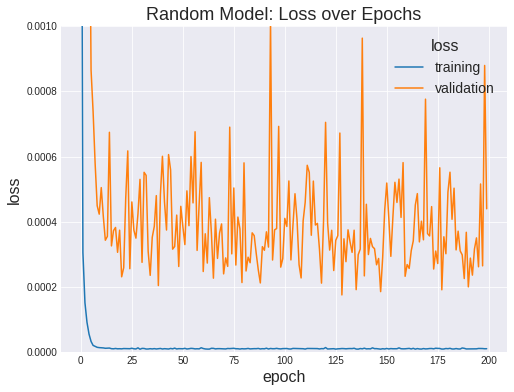

time: 161 ms (started: 2021-04-20 03:45:50 +00:00)


In [ ]:
plt.figure(figsize=(8, 6))
plt.title('Random Model: Loss over Epochs', fontsize=18)
plt.plot(random_history['train_loss'], label='training')
plt.plot(random_history['val_loss'], label='validation')
plt.xlabel('epoch', fontsize=16)
plt.ylabel('loss', fontsize=16)
plt.ylim(0, 0.001)
plt.legend(
    title='loss',
    title_fontsize=16,
    fontsize=14,
    loc='upper right')
plt.show()

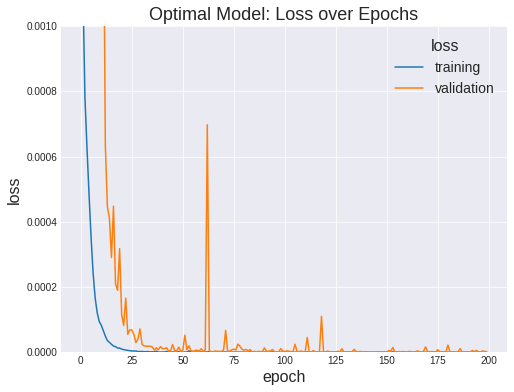

time: 230 ms (started: 2021-04-20 19:07:28 +00:00)


In [ ]:
plt.figure(figsize=(8, 6))
plt.title('Optimal Model: Loss over Epochs', fontsize=18)
plt.plot(optconf_history['train_loss'], label='training')
plt.plot(optconf_history['val_loss'], label='validation')
plt.xlabel('epoch', fontsize=16)
plt.ylabel('loss', fontsize=16)
plt.ylim(0, 0.001)
plt.legend(
    title='loss',
    title_fontsize=16,
    fontsize=14,
    loc='upper right')
plt.show()

# Testing

## Testing Function

In [ ]:
def test(model, batch_size=128, verbose=True):
    """
    Tests a model.

    Parameters
    ----------
    model : LangyNet
        The model to test.
    batch_size : int, default=128
        Number of examples per batch.
    verbose : bool, default=True
        Control whether to print loss while testing.
    
    Returns
    -------
    test_loss : list of float
        History of testing loss.
    min : float
        Minimum testing loss of a single batch.
    max : float
        Maximum testing loss of a single batch.
    avg : float
        Average testing loss across all batches.
    """

    if isinstance(model, torch.nn.Module):
        model.eval()  # evaluation mode

    # CPU/GPU processing
    device = 'cpu'
    if torch.cuda.is_available():
        device = 'cuda:0'
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)

    # Ensure we test on unseen data
    # random_state=1 used by tuning function to produce model
    train_dataset, test_dataset = load_data(random_state=1)
    test_loader = data.DataLoader(test_dataset, batch_size, shuffle=True)
    if verbose:
        print(f'Testing dataset contains {len(test_dataset)} examples.\n'
              f'Batch size set to {batch_size}.\n')

    # Calculate and track loss
    loss_fn = nn.MSELoss()
    test_loss = []
    min, max = 0, 0

    for batch, (X, y) in enumerate(test_loader):
        with torch.no_grad():
            # CPU/GPU processing
            X, y = X.to(device), y.to(device)

            # Computations
            y_hat = model(X)          # compute prediction
            loss = loss_fn(y_hat, y)  # calculate loss

            # Track batch loss
            # sum of testing loss / number of examples
            batch_loss = float(loss.sum()) / y.numel()
            test_loss.append(batch_loss)
            if batch == 0:
                min, max = batch_loss, batch_loss
            else:
                if batch_loss < min: min = batch_loss
                if batch_loss > max: max = batch_loss

            # Display loss
            if verbose and (batch == 0 or (batch + 1) % 100 == 0):
                print(f'batch {batch+1 :<4} ',
                      f'test_loss={batch_loss:.11f}')

    avg = sum(test_loss) / len(test_loss)
    if verbose:
        print('\n\n',
              f'min={min:.11f} ({min})\n',
              f'max={max:.11f} ({max})\n',
              f'avg={avg:.11f} ({avg})\n')

    return test_loss, min, max, avg

time: 36.1 ms (started: 2021-04-20 19:08:03 +00:00)


## Load Model

In [31]:
# Initialise a model
model = LangyNet(hidden_layers=3, hidden_nodes=32)

# Load state from file
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda:0'
model.load_state_dict(torch.load(
    '/content/gdrive/MyDrive/Uni/Year 3/ECS635U Project/model_state_dict',
    map_location=torch.device(device)))

# Set model to evaluation mode
model.eval()

# Display model state (parameters i.e. weights and bias)
# for param_tensor in model.state_dict():
#     print(param_tensor, '\n', model.state_dict()[param_tensor])

LangyNet(
  (langy_block_1): LangyBlock(
    (hid1): Linear(in_features=10, out_features=32, bias=True)
    (act1): ReLU()
    (drop1): Dropout(p=0, inplace=False)
  )
  (langy_block_2): LangyBlock(
    (hid2): Linear(in_features=32, out_features=32, bias=True)
    (act2): ReLU()
    (drop2): Dropout(p=0, inplace=False)
  )
  (langy_block_3): LangyBlock(
    (hid3): Linear(in_features=32, out_features=32, bias=True)
    (act3): ReLU()
    (drop3): Dropout(p=0, inplace=False)
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

time: 17.3 ms (started: 2021-04-20 21:44:12 +00:00)


## Perform Testing

In [32]:
test_loss, min, max, avg = test(model)

Testing dataset contains 146763 examples.
Batch size set to 128.

batch 1     test_loss=0.00000000201
batch 100   test_loss=0.00000000150
batch 200   test_loss=0.00000000117
batch 300   test_loss=0.00000000339
batch 400   test_loss=0.00000000145
batch 500   test_loss=0.00000000132
batch 600   test_loss=0.00000000131
batch 700   test_loss=0.00000000146
batch 800   test_loss=0.00000000200
batch 900   test_loss=0.00000000186
batch 1000  test_loss=0.00000000178
batch 1100  test_loss=0.00000000166


 min=0.00000000070 (6.993137180444364e-10)
 max=0.00000000866 (8.660061112664152e-09)
 avg=0.00000000160 (1.6026830085248343e-09)

time: 3.11 s (started: 2021-04-20 21:44:16 +00:00)


## Plot of Loss

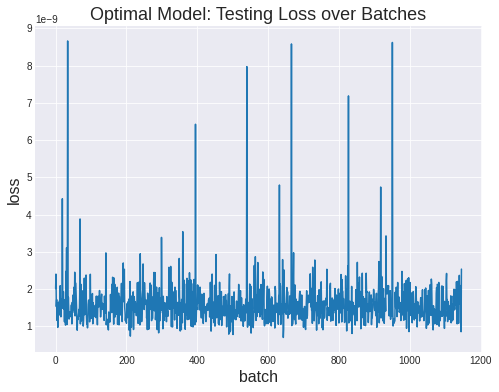

time: 182 ms (started: 2021-04-20 21:44:23 +00:00)


In [33]:
plt.figure(figsize=(8, 6))
plt.title('Optimal Model: Testing Loss over Batches', fontsize=18)
plt.plot(test_loss)
plt.xlabel('batch', fontsize=16)
plt.ylabel('loss', fontsize=16)
plt.show()